20250227

**Destilled Vortex is a lighter version of the model trained only with the most important variables obtained from [feature importance analysis](./Full_model+feature_importance.ipynb).**


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pycaret.classification import * # Machine learning tools
import imblearn  # Resampling
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import ConfusionMatrixDisplay # Model evaluation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns
from sklearn.metrics import classification_report # Model evaluation report


In [6]:
#Loading data
#df = pd.read_csv("/home/dsg/VORTEX_FINAL/PRODUCTION/DATA/processed/training_data.csv", encoding='latin-1') 
df = pd.read_excel('./data/final_input_data.xlsx', engine='openpyxl')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778 entries, 0 to 1777
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1778 non-null   int64  
 1   Al          1778 non-null   float64
 2   Si          1778 non-null   float64
 3   P           1778 non-null   float64
 4   S           1778 non-null   float64
 5   Cl          1778 non-null   float64
 6   K           1778 non-null   float64
 7   Ca          1778 non-null   float64
 8   Sc          1778 non-null   float64
 9   Ti          1778 non-null   float64
 10  V           1778 non-null   float64
 11  Cr          1778 non-null   float64
 12  Mn          1778 non-null   float64
 13  Fe          1778 non-null   float64
 14  Co          1778 non-null   float64
 15  Ni          1778 non-null   float64
 16  Cu          1778 non-null   float64
 17  Zn          1778 non-null   float64
 18  Ga          1778 non-null   float64
 19  Ge          1778 non-null  

In [4]:
data = data.drop(['rand','Unnamed: 0'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778 entries, 0 to 1777
Data columns (total 46 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      1778 non-null   float64
 1   Si      1778 non-null   float64
 2   P       1778 non-null   float64
 3   S       1778 non-null   float64
 4   Cl      1778 non-null   float64
 5   K       1778 non-null   float64
 6   Ca      1778 non-null   float64
 7   Sc      1778 non-null   float64
 8   Ti      1778 non-null   float64
 9   V       1778 non-null   float64
 10  Cr      1778 non-null   float64
 11  Mn      1778 non-null   float64
 12  Fe      1778 non-null   float64
 13  Co      1778 non-null   float64
 14  Ni      1778 non-null   float64
 15  Cu      1778 non-null   float64
 16  Zn      1778 non-null   float64
 17  Ga      1778 non-null   float64
 18  Ge      1778 non-null   float64
 19  As      1778 non-null   float64
 20  Se      1778 non-null   float64
 21  Br      1778 non-null   float64
 22  

In [5]:
data.isnull().any().any()


False

In [6]:
#CT== can_tintorer
#PDLC== aliste
#PCM== encinasola

# Distribución en el target
target = data['Site'].value_counts()
target

Site
CT      828
PDLC    511
PCM     439
Name: count, dtype: int64

In [5]:
fvs = pd.read_excel('./data/final_validation_set.xlsx')
fvs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  178 non-null    int64  
 1   Al          178 non-null    float64
 2   Si          178 non-null    float64
 3   P           178 non-null    float64
 4   S           178 non-null    float64
 5   Cl          178 non-null    float64
 6   K           178 non-null    float64
 7   Ca          178 non-null    float64
 8   Sc          178 non-null    float64
 9   Ti          178 non-null    float64
 10  V           178 non-null    float64
 11  Cr          178 non-null    float64
 12  Mn          178 non-null    float64
 13  Fe          178 non-null    float64
 14  Co          178 non-null    float64
 15  Ni          178 non-null    float64
 16  Cu          178 non-null    float64
 17  Zn          178 non-null    float64
 18  Ga          178 non-null    float64
 19  Ge          178 non-null    f

In [8]:
# Looking for common ids

# 1. Crear data_trainning eliminando las filas de 'data' cuyos 'id' están en 'vs1'
data_trainning = data[~data['id'].isin(fvs['id'])]

# 2. Reiniciar los índices si es necesario
data_trainning.reset_index(drop=True, inplace=True)

# 3. Verificar los resultados
print('Data original shape:', data.shape)
print('Validation set shape:', fvs.shape)
print('Training data shape:', data_trainning.shape)

# 4. Opcionalmente, verificar que no hay ids de fvs en data_trainning
common_ids = set(data_trainning['id']).intersection(set(fvs['id']))
print('Number of common ids (should be 0):', len(common_ids))

Data original shape: (1778, 46)
Validation set shape: (178, 47)
Training data shape: (1600, 46)
Number of common ids (should be 0): 0


In [9]:
data_trainning.Site.value_counts()

Site
CT      752
PDLC    457
PCM     391
Name: count, dtype: int64

In [10]:
fvs.Site.value_counts()

Site
CT      76
PDLC    54
PCM     48
Name: count, dtype: int64

#### Distilling the knowledge gained from previous iterations: 

We are going to perform a feature selection task based on the feature importance analysis.

In [11]:
trainning_features = ['Ca','S', 'K', 'Ti', 'V', 'Cr', 'Cu', 
                      'Zn', 'As', 'Se', 'Sr', 
                      'Mo','Ba', 
                      'Ta', 'Site']

data_trainning = data_trainning[trainning_features] 

In [12]:
#pool of available features
"""
['Al', 'Si', 'P', 'S', 'Cl', 'K', 
 'Ca', 'Ti', 'V', 'Cr', 'Fe', 'Ni',
 'Cu', 'Zn', 'As', 'Se', 'Rb', 'Sr', 
 'Zr', 'Mo', 'Ag', 'In', 'Sn', 'Sb',
 'Ba', 'Ta', 'W', 'Tl', 'Site']
 """

"\n['Al', 'Si', 'P', 'S', 'Cl', 'K', \n 'Ca', 'Ti', 'V', 'Cr', 'Fe', 'Ni',\n 'Cu', 'Zn', 'As', 'Se', 'Rb', 'Sr', \n 'Zr', 'Mo', 'Ag', 'In', 'Sn', 'Sb',\n 'Ba', 'Ta', 'W', 'Tl', 'Site']\n "

In [13]:
data_trainning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ca      1600 non-null   float64
 1   S       1600 non-null   float64
 2   K       1600 non-null   float64
 3   Ti      1600 non-null   float64
 4   V       1600 non-null   float64
 5   Cr      1600 non-null   float64
 6   Cu      1600 non-null   float64
 7   Zn      1600 non-null   float64
 8   As      1600 non-null   float64
 9   Se      1600 non-null   float64
 10  Sr      1600 non-null   float64
 11  Mo      1600 non-null   float64
 12  Ba      1600 non-null   float64
 13  Ta      1600 non-null   float64
 14  Site    1600 non-null   object 
dtypes: float64(14), object(1)
memory usage: 187.6+ KB


#### Creating our Classification function:


In [14]:
X = data_trainning.drop(['Site'], axis=1)
y = data_trainning['Site']

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ca      1600 non-null   float64
 1   S       1600 non-null   float64
 2   K       1600 non-null   float64
 3   Ti      1600 non-null   float64
 4   V       1600 non-null   float64
 5   Cr      1600 non-null   float64
 6   Cu      1600 non-null   float64
 7   Zn      1600 non-null   float64
 8   As      1600 non-null   float64
 9   Se      1600 non-null   float64
 10  Sr      1600 non-null   float64
 11  Mo      1600 non-null   float64
 12  Ba      1600 non-null   float64
 13  Ta      1600 non-null   float64
dtypes: float64(14)
memory usage: 175.1 KB


In [16]:
y.value_counts()

Site
CT      752
PDLC    457
PCM     391
Name: count, dtype: int64

#### Data Aumentagtion of minority classes (SMOTE)

Site
PDLC    752
CT      752
PCM     752
Name: count, dtype: int64

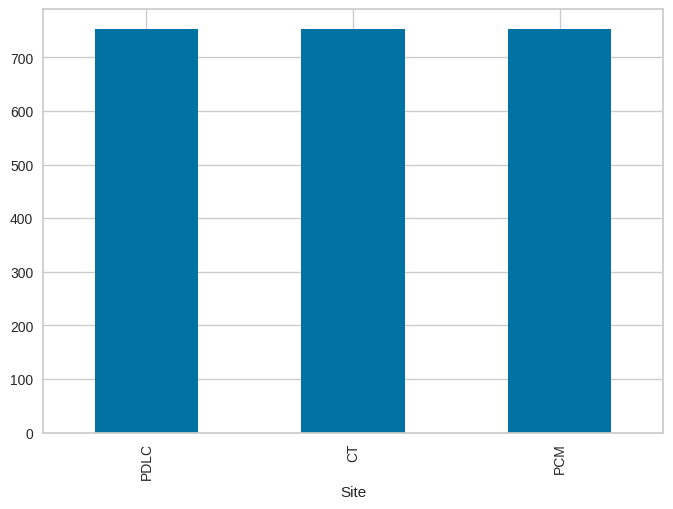

In [17]:
# oversampling strategy
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

y_smote.value_counts().plot(kind='bar')
#plt.savefig('SMOTE_distribution.png',dpi=200, bbox_inches='tight')
y_smote.value_counts()

In [18]:
# Creating final resampled dataset
smote_data = X_smote
smote_data['Site'] = y_smote

In [19]:
# Final dataset shape after resampling
smote_data.shape
smote_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ca      2256 non-null   float64
 1   S       2256 non-null   float64
 2   K       2256 non-null   float64
 3   Ti      2256 non-null   float64
 4   V       2256 non-null   float64
 5   Cr      2256 non-null   float64
 6   Cu      2256 non-null   float64
 7   Zn      2256 non-null   float64
 8   As      2256 non-null   float64
 9   Se      2256 non-null   float64
 10  Sr      2256 non-null   float64
 11  Mo      2256 non-null   float64
 12  Ba      2256 non-null   float64
 13  Ta      2256 non-null   float64
 14  Site    2256 non-null   object 
dtypes: float64(14), object(1)
memory usage: 264.5+ KB


In [20]:
# Experiment setup 

experiment = setup(data=smote_data, target= 'Site',train_size=0.8, session_id=123)

,Description,Value
0,Session id,123
1,Target,Site
2,Target type,Multiclass
3,Target mapping,"CT: 0, PCM: 1, PDLC: 2"
4,Original data shape,"(2256, 15)"
5,Transformed data shape,"(2256, 15)"
6,Transformed train set shape,"(1804, 15)"
7,Transformed test set shape,"(452, 15)"
8,Numeric features,14
9,Preprocess,True


In [21]:
remove_metric('MCC')
remove_metric('Kappa')
remove_metric('AUC')
#'AUC', , 'MCC'

In [22]:
#destilled random forest (drf)
drf = create_model('rf',n_estimators=200,
                  min_samples_leaf=5,
                  class_weight="balanced", 
                  criterion='entropy',
                  random_state=42)

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9724,0.9724,0.9726,0.9725
1,0.9669,0.9669,0.9671,0.9668
2,0.9724,0.9724,0.9738,0.9722
3,0.9724,0.9724,0.9727,0.9722
4,0.9611,0.9611,0.9615,0.9612
5,0.9556,0.9556,0.9559,0.9556
6,0.9611,0.9611,0.9628,0.9613
7,0.9722,0.9722,0.9723,0.9722
8,0.9278,0.9278,0.9286,0.9270


In [23]:
X_train = get_config(variable="X_train")
y_train = get_config(variable="y_train")

X_test = get_config(variable="X_test")
y_test = get_config(variable="y_test")
y_test.value_counts()

Site
PCM     151
PDLC    151
CT      150
Name: count, dtype: int64

In [24]:
tuned_model = tune_model(drf, n_iter=10, 
                         tuner_verbose=True, 
                         optimize='F1', 
                         custom_grid = 
                         {'criterion': ['entropy'],              
                          'min_samples_leaf':[5, 10, 15, 20, 25, 30]
                         })

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9669,0.9669,0.9669,0.9668
1,0.9724,0.9724,0.9729,0.9725
2,0.9724,0.9724,0.9727,0.9722
3,0.9613,0.9613,0.9617,0.9613
4,0.9611,0.9611,0.9615,0.9612
5,0.9556,0.9556,0.9559,0.9556
6,0.9667,0.9667,0.9687,0.9668
7,0.9667,0.9667,0.9669,0.9667
8,0.9222,0.9222,0.9234,0.9212


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Model Calibration:
This function calibrates the probability of a given estimator using isotonic or logistic regression. The output of this function is a score grid with CV scores by fold.
By default function uses Logistic regression model to transform probabilities.
We chose this method to take into account the following library documentation [warning](https://pycaret.readthedocs.io/en/latest/api/classification.html#pycaret.classification.calibrate_model) and avoid overfitting. 


In [26]:

cal_model = calibrate_model(drf, method='sigmoid')

,Accuracy,Recall,Prec.,F1
Fold,,,,
0,0.9669,0.9669,0.9671,0.9669
1,0.9724,0.9724,0.9729,0.9725
2,0.9779,0.9779,0.9788,0.9778
3,0.9724,0.9724,0.9727,0.9722
4,0.9611,0.9611,0.9615,0.9612
5,0.9556,0.9556,0.9559,0.9556
6,0.9611,0.9611,0.9628,0.9613
7,0.9667,0.9667,0.9669,0.9667
8,0.9167,0.9167,0.9181,0.9158


In [27]:
#Calibrated model evaluated against test data
last_training_predictions = predict_model(cal_model)

y_true = y_test
y_pred = last_training_predictions['prediction_label']
class_rep = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
#class_rep.to_csv('./TABLES/20240826_classificationReportDestilledVortexTestData.csv')
class_rep


,Model,Accuracy,Recall,Prec.,F1
0,Random Forest Classifier,0.9646,0.9646,0.9647,0.9646


,precision,recall,f1-score,support
CT,0.979730,0.966667,0.973154,150.000000
PCM,0.947712,0.960265,0.953947,151.000000
PDLC,0.966887,0.966887,0.966887,151.000000
accuracy,0.964602,0.964602,0.964602,0.964602
macro avg,0.964777,0.964606,0.964663,452.000000
weighted avg,0.964743,0.964602,0.964644,452.000000


In [28]:
# Final training iteration with all available data
final_model = finalize_model(cal_model)


In [29]:
unseen_predictions = predict_model(final_model, data=fvs)
unseen_predictions

,Model,Accuracy,Recall,Prec.,F1
0,Random Forest Classifier,0.9494,0.9494,0.9499,0.9495


,Al,Si,P,S,Cl,K,Ca,Sc,Ti,V,...,Au,Hg,Tl,Pb,Th,suma,id,Site,prediction_label,prediction_score
0,16.967108,58.748379,16.361971,0.471474,1.349358,0.005982,0.158800,0.005982,0.244552,0.110844,...,0.000598,0.000598,0.000598,0.000051,0.000598,99.999451,0088-03,PDLC,PDLC,0.9864
1,31.785463,29.897738,30.298309,0.986918,1.875399,0.833437,0.668119,0.005310,0.273988,0.407125,...,0.000531,0.000531,0.000531,0.000010,0.000531,99.999481,0091-02,PDLC,PDLC,0.9789
2,38.207870,17.721268,37.159813,0.472849,1.671586,0.005075,0.005075,0.005075,0.318398,0.005075,...,0.000508,0.000508,0.000508,0.000010,0.000508,99.999504,0092-05,PDLC,PDLC,0.9905
3,43.829479,13.649417,32.084663,0.268403,0.976809,0.005196,0.119411,0.005196,0.062420,0.005196,...,0.000520,0.000520,0.000520,0.000010,0.000520,99.999489,0099-01,PDLC,PDLC,0.9803
4,10.076868,46.039585,14.790862,0.824680,3.853663,0.006428,0.167289,0.006428,0.736598,0.006428,...,0.000643,0.000643,0.000643,0.001171,0.000643,100.000526,0111-01,PDLC,PDLC,0.9660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,29.133850,12.200644,28.188839,0.339457,1.678676,0.985179,22.377140,0.005385,0.517829,0.005385,...,0.000538,0.000538,0.000538,0.000010,0.000538,99.999474,MP-421,CT,CT,0.9883
174,29.224028,39.126438,12.966257,0.540606,1.775522,1.965273,10.365994,0.005863,0.427249,0.107501,...,0.000586,0.000586,0.000586,0.000010,0.000586,99.999420,MP-668,CT,CT,0.9888
175,1.973777,14.026845,0.234887,18.849106,1.987404,0.007057,3.380771,0.007057,0.049239,0.007057,...,0.000706,0.000706,0.000706,0.000010,0.000706,99.999306,MP-882,CT,PDLC,0.7935
176,26.421036,12.490799,36.550430,0.477651,2.640254,1.098620,3.650473,0.005430,0.652768,0.235262,...,0.000543,0.000543,0.000543,0.000010,0.000543,99.999466,Ferreres_Superficie_9msudtallnort_12,CT,CT,0.9883


In [30]:
#Evaluating final model on final validation set
y_true = unseen_predictions['Site']
y_pred = unseen_predictions['prediction_label']
class_rep = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
#class_rep.to_csv('./TABLES/classificationReportFVSDestilledVortex.csv')
class_rep

,precision,recall,f1-score,support
CT,0.973333,0.960526,0.966887,76.000000
PCM,0.920000,0.958333,0.938776,48.000000
PDLC,0.943396,0.925926,0.934579,54.000000
accuracy,0.949438,0.949438,0.949438,0.949438
macro avg,0.945577,0.948262,0.946747,178.000000
weighted avg,0.949869,0.949438,0.949505,178.000000


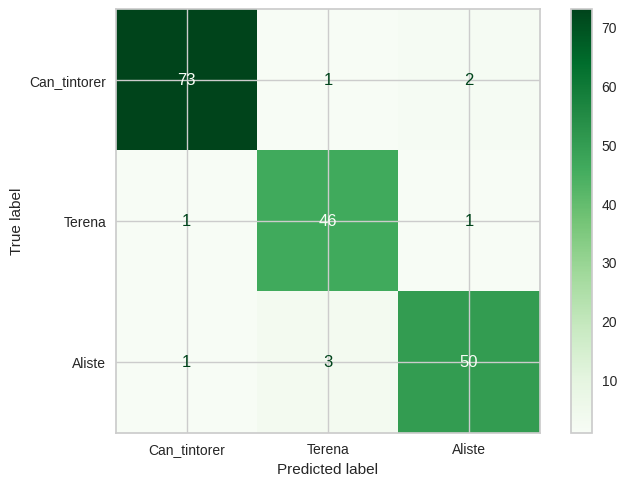

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= ['Can_tintorer', 'Terena', 'Aliste'])
disp.plot(cmap='Greens')
#plt.savefig("./FIGURES/20240826_DestilledVortex2VS1_ConfMatrix.png",bbox_inches='tight')


### Save the Model
This function saves the transformation pipeline and trained model object into the current working directory as a pickle file for later use.

In [32]:
save_model(final_model, model_name = './models/rf_Destilled',verbose=True)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Ca', 'S', 'K', 'Ti', 'V', 'Cr',
                                              'Cu', 'Zn', 'As', 'Se', 'Sr', 'Mo',
                                              'Ba', 'Ta'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,...
                                                                          class_weight='balanced',
                                                                          criterion='entropy',
                         